## Demo of STMatch Python API

In [7]:
from fmm import Network,NetworkGraph,STMATCH,STMATCHAlgorConfig

In [8]:
network = Network("../example/data/edges.shp")
graph = NetworkGraph(network)
print graph.get_num_vertices()
model = STMATCH(network,graph)

17


In [9]:
wkt = "LINESTRING(0.200812146892656 2.14088983050848,1.44262005649717 2.14879943502825,3.06408898305084 2.16066384180791,3.06408898305084 2.7103813559322,3.70872175141242 2.97930790960452,4.11606638418078 2.62337570621469)"

In [10]:
config = STMATCHAlgorConfig()
config.k = 4
config.gps_error = 0.5
config.radius = 0.4

In [11]:
result = model.match_wkt_test(wkt,config)
print type(result)

TypeError: match_wkt_test() takes exactly 4 arguments (3 given)

In [30]:
print type(network.this)

<type 'SwigPyObject'>


In [76]:
from ipyleaflet import *

In [90]:
from shapely.wkt import dumps, loads
from shapely.geometry import mapping
route = mapping(loads(geom.export_wkt()))
m = Map(center=(59.334591, 18.063240), zoom=10, basemap=basemaps.OpenStreetMap.Mapnik)
original_geo_json = GeoJSON(data=route, style = {'color': 'red', 'opacity':0.5, 'weight':8})                
m.add_layer(original_geo_json)
m

TWFwKGNlbnRlcj1bNTkuMzM0NTkxLCAxOC4wNjMyNF0sIGNvbnRyb2xzPShab29tQ29udHJvbChvcHRpb25zPVt1J3Bvc2l0aW9uJywgdSd6b29tX2luX3RleHQnLCB1J3pvb21faW5fdGl0bGXigKY=


### Run map matching

### Print the match result

In [4]:
print "Matched path geometry",result.mgeom
print "Matched points geometry",result.pgeom
print "Matched edge id",list(result.opath)
print "Matched path edges",list(result.cpath)

Matched path geometry LINESTRING(0.200812146068 2,1 2,2 2,3 2,3 3,4 3,4 2.62337571383)
Matched points geometry LINESTRING(0.200812146068 2,1.44262006879 2,3 2.16066384315,3 2.71038132906,3.70872175694 3,4 2.62337571383)
Matched edge id [8, 11, 18, 18, 20, 24]
Matched path edges [8, 11, 13, 18, 20, 24]


### Verification of the matching result

Check the candidates and transition lattice

In [5]:
import pandas as pd
def candidates2df(candidates):
    return pd.DataFrame([(v.index,v.edge_id,v.source,v.target,v.distance,v.length,v.offset,v.ep) for v in candidates],
                        columns=['index','edge_id','source','target','dist','length','offset','ep'])
def lattice2df(lattice):
    return pd.DataFrame([(v.index,v.from_edge,v.to_edge,v.eu_dist,v.sp_dist,v.tp,v.e_prob,v.cumu_prob) for v in lattice],
                  columns=['index','f_edge','t_edge','eu_dist','sp_dist','tp','ep','cp'])

In [6]:
candidates = model.search_candidate(wkt)
df = candidates2df(candidates)
print df.head()

   index  edge_id  source  target      dist  length    offset        ep
0      0        8       7       8  0.140890     1.0  0.200812  0.961078
1      0        9       8       7  0.140890     1.0  0.799188  0.961078
2      1       10       5       8  0.148799     1.0  0.557380  0.956684
3      1       11       8       5  0.148799     1.0  0.442620  0.956684
4      2       18       6      11  0.064089     1.0  0.160664  0.991819


In [9]:
lattice = model.build_transition_lattice(wkt)
df = lattice2df(lattice)
print df.head()

   index  f_edge  t_edge   eu_dist   sp_dist        tp        ep        cp
0      0       8      10  1.241833  2.356568  0.526967  0.956684  1.465218
1      0       8      11  1.241833  1.241808  0.999980  0.956684  1.917742
2      0       9      10  1.241833  2.758192  0.450234  0.956684  1.391810
3      0       9      11  1.241833  1.643432  0.755634  0.956684  1.683980
4      1      10      18  1.621512  2.603284  0.622872  0.991819  2.082994


### Visualize the result

You need to have `pyshp` and `shapely` installed. You can install it with `pip`.

```
pip install pyshp shapely
```

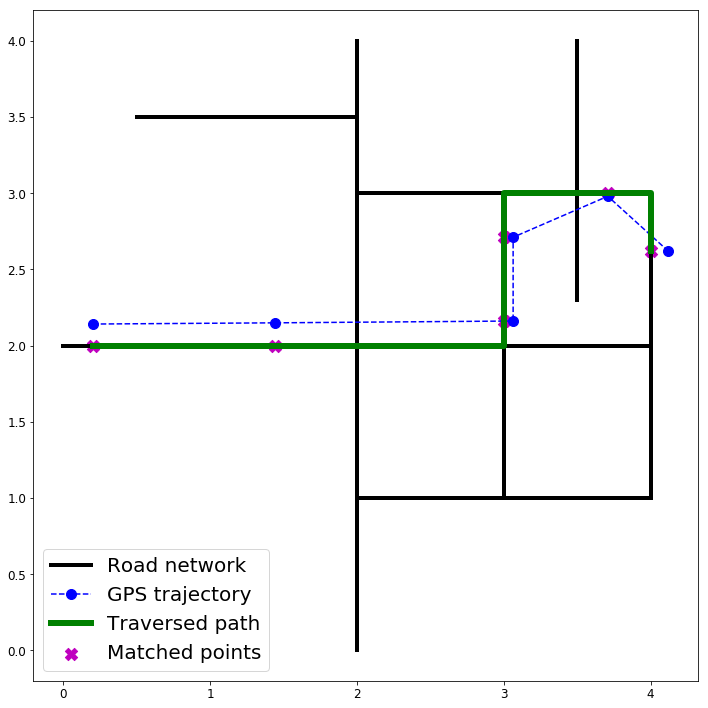

In [10]:
%matplotlib inline
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sf = shp.Reader("../example/data/edges.shp")

# Plot road network
plt.figure(figsize=(10,10))
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    line, = plt.plot(x,y,c='k',lw=4)
line.set_label("Road network")

# Plot the trajectory 
from shapely.wkt import dumps, loads
gps_geom = loads(wkt)
x,y = gps_geom.xy
plt.plot(x,y,label="GPS trajectory",linestyle='--', marker='o', color='b',markersize=10)

# Plot the matched result
matched_path_geom = loads(result.mgeom)
matched_points_geom = loads(result.pgeom)
x,y = matched_path_geom.xy
plt.plot(x,y,c='g',label="Traversed path",lw=6)

x,y = matched_points_geom.xy
plt.scatter(x,y,label="Matched points", marker='X', c='m',s=150)
plt.legend(loc='lower left',fontsize=20)
plt.tight_layout()
